In [1]:
import os
import sys
from pathlib import Path
sys.path.append(os.path.join(Path().resolve(), '..'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [3]:
df = pd.read_csv('../data/titanic/train.csv')
df_ = pd.read_csv('../data/titanic/test.csv')
df_ori = df_.copy()

In [4]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
df_.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
# これらのカラムは今回用いない
df = df.drop(['PassengerId', 'Name', 'Cabin', 'Embarked', 'Ticket'], axis=1)
df_ = df_.drop(['PassengerId', 'Name', 'Cabin', 'Embarked', 'Ticket'], axis=1)

In [9]:
# one hotエンコーディングにする
df = pd.get_dummies(df, columns=["Sex"])
df_ = pd.get_dummies(df_, columns=["Sex"])

In [10]:
# 中央値を用いて欠損値処理
df.fillna(df.median(), inplace=True)
df_.fillna(df_.median(), inplace=True)

In [11]:
df.head(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,False,True
1,1,1,38.0,1,0,71.2833,True,False


In [12]:
df_.head(2)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,3,34.5,0,0,7.8292,False,True
1,3,47.0,1,0,7.0000,True,False


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    bool   
 7   Sex_male    891 non-null    bool   
dtypes: bool(2), float64(2), int64(4)
memory usage: 43.6 KB


In [14]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        418 non-null    float64
 5   Sex_female  418 non-null    bool   
 6   Sex_male    418 non-null    bool   
dtypes: bool(2), float64(2), int64(3)
memory usage: 17.3 KB


In [15]:
#　切片を計算するため1を挿入
df.insert(0, 'Const', 1)
df_.insert(0, 'Const', 1)

In [16]:

def calculate_train_loss(x, y, λ):
    I = np.eye(x.T.shape[0])
    w = np.linalg.inv(x.T @ x + λ * I) @ x.T @ y # Ridge回帰により求める

    # 損失関数の計算（例えば平均二乗誤差）
    loss = np.mean((x @ w - y) ** 2)

    return w, loss

def calculate_val_loss(w, x, y, λ):
    # 損失関数の計算（例えば平均二乗誤差）
    loss = np.mean((x @ w - y) ** 2)

    return loss

Best λ: 0.1573469387755102
Best loss: 0.1451932841495142


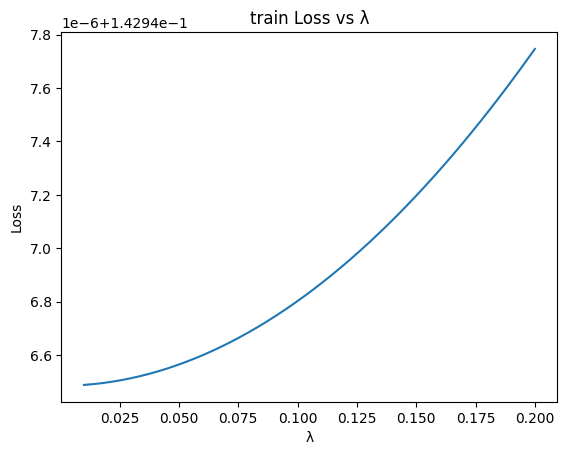

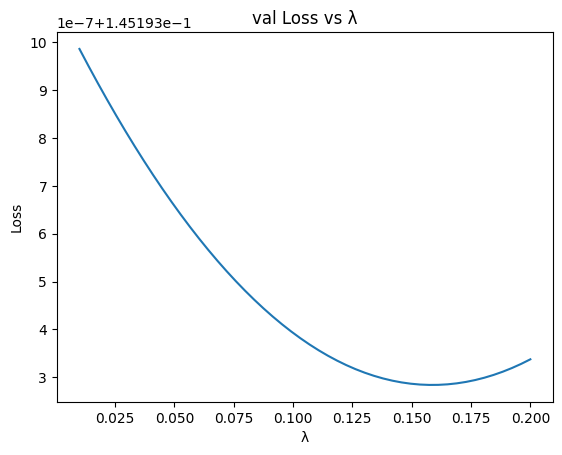

In [17]:
# 特徴量とターゲット変数を取得
X = df.drop('Survived', axis=1).astype(float)
y = df['Survived'].astype(float)



# k 分割交差検証の設定
k = 5  # 分割数
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)


# 損失関数のグラフをプロットするための準備
λ_values = np.linspace(0.01, 0.2, 50)   # λ の候補値を設定
train_losses = []
val_losses = []

# 各分割での検証とモデル学習
for λ in λ_values:
    fold_train_losses = []
    fold_val_losses = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values

        y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values
        
        # trainの損失関数の計算
        w, train_loss = calculate_train_loss(X_train, y_train, λ)
        fold_train_losses.append(train_loss)
        
        # valの損失関数の計算
        val_loss = calculate_val_loss(w, X_test, y_test, λ)
        fold_val_losses.append(val_loss)
        

    # 各分割の損失を平均した値を追加
    train_losses.append(np.mean(fold_train_losses))
    val_losses.append(np.mean(fold_val_losses))

# 最適な λ の取得
best_λ = λ_values[np.argmin(val_losses)]
best_loss = np.min(val_losses)

print("Best λ:", best_λ)
print("Best loss:", best_loss)

# 損失関数のグラフをプロット
plt.plot(λ_values, train_losses)
plt.xlabel("λ")
plt.ylabel("Loss")
plt.title("train Loss vs λ")
plt.savefig("../logs/fig/train_loss.pdf")
plt.show()
plt.plot(λ_values, val_losses)
plt.xlabel("λ")
plt.ylabel("Loss")
plt.title("val Loss vs λ")
plt.savefig("../logs/fig/val_loss.pdf")
plt.show()

In [18]:
X = df.drop('Survived', axis=1).astype(float).values
y = df[['Survived']].astype(float).values
best_w, loss = calculate_train_loss(X, y, best_λ)
best_w

array([[ 6.92070638e-01],
       [-1.69769927e-01],
       [-5.80273430e-03],
       [-4.35232009e-02],
       [-1.90513476e-02],
       [ 4.21152887e-04],
       [ 6.02170358e-01],
       [ 8.99002801e-02]])

In [19]:
def calculate_accuracy(predictions, ground_truth):
    total = len(ground_truth)
    
    correct = 0

    for i in range(total):
        
        if predictions[i] == ground_truth[i]:
            
            correct += 1

    accuracy = correct / total
    return accuracy

Best threshold: 0.58
Best accuracy: 0.8148148148148148


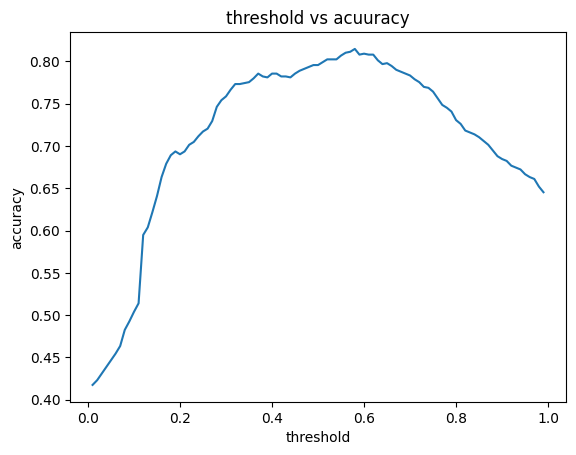

In [20]:
# リッジ回帰により求めた値をthresholdで2値化
best_thrr = None
best_accuracy = 0
history = []
pre = X@best_w

for thrr in range(1, 100):
    thrr /= 100
    modified_ans = pre.copy()

    for i, value in enumerate(modified_ans):
        if value > thrr:
            modified_ans[i] = 1
        else:
            modified_ans[i] = 0

    accuracy = calculate_accuracy(modified_ans, y)  # 予測結果と正解の比較により正確性を計算
    history.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_thrr = thrr

x = np.arange(0.01, 1, 0.01)
len(x)
plt.plot(x, history)
plt.xlabel("threshold")
plt.ylabel("accuracy")
plt.title("threshold vs acuuracy")
plt.savefig("../logs/fig/threshold_vs_acuuracy.pdf")
print("Best threshold:", best_thrr)
print("Best accuracy:", best_accuracy)

In [21]:
X_ = df_.astype(float).values
ans = X_@best_w
for i, value in enumerate(ans):
    if value > best_thrr:
        ans[i] = 1
    else:
        ans[i] = 0

In [22]:
submit_csv = pd.concat([df_ori['PassengerId'], pd.Series(ans.flatten(), dtype=int)], axis=1)
submit_csv.columns = ['PassengerId', 'Survived']
# 提出用ファイルの作成
submit_csv.to_csv('../logs/xlsx/submission.csv', index=False)

In [23]:
pd.read_csv('../logs/xlsx/submission.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
